In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import math
import time
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from IPython.display import clear_output
import os
%matplotlib inline
import argparse
/content/drive/MyDrive/DataFiles/startups.csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/DataFiles/startups.csv')

# Shuffle the data
data = shuffle(data)

# Display the first 8 rows
data.head(8)

,R&D Spend,Administration,Marketing Spend,State,Profit
5,131876.90,99814.71,362861.36,New York,156991.12
10,101913.08,110594.11,229160.95,Florida,146121.95
21,78389.47,153773.43,299737.29,New York,111313.02
28,66051.52,182645.56,118148.20,Florida,103282.38
15,114523.61,122616.84,261776.23,New York,129917.04
1,162597.70,151377.59,443898.53,California,191792.06
30,61994.48,115641.28,91131.24,Florida,99937.59
49,0.00,116983.80,45173.06,California,14681.40


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 5 to 39
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.3+ KB


In [8]:
# Grouping features into one feature
data['Spent'] = data['R&D Spend'] + data['Marketing Spend'] + data['Administration']

# Scale the data
scaler = StandardScaler()
data[['Spent','Profit']] = scaler.fit_transform(data[['Spent','Profit']])

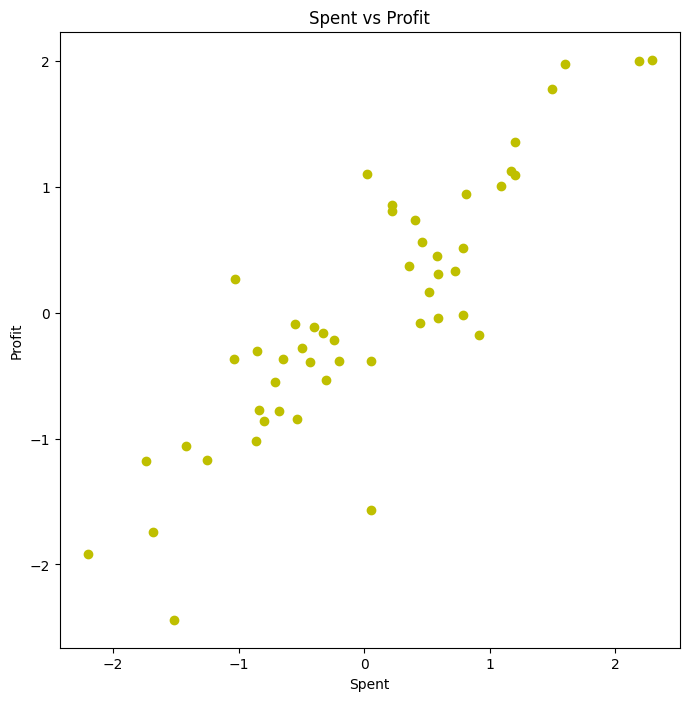

In [10]:
# Plot the data
plt.figure(figsize=(8,8))
plt.title("Spent vs Profit")
plt.xlabel("Spent")
plt.ylabel("Profit")
plt.plot(data['Spent'], data['Profit'], 'yo')
plt.show()

In [11]:
# Forward propagation function
def forward(gamma, X):
    """Performs forward propagation for linear regression.

    Args:
        gamma: A list [w, b] where w is the weight and b is the bias
        X: The input dataset

    Returns:
        Computed values obtained by applying the linear regression equation.
    """
    w,b = gamma
    z = X * w + b
    return z

In [12]:
# Loss function
def loss_function(y, y_hat):
    """Calculates the mean squared error between the predicted and true values.

    Args:
        y: The true values.
        y_hat: The predicted values.

    Returns:
        The mean squared error.
    """
    return 1/2 * (y_hat - y) ** 2

In [13]:
# Derivative of the loss function
def dloss(y, y_hat):
    """Calculates the derivative of the mean squared error loss function.

    Args:
        y: The true values.
        y_hat: The predicted values.

    Returns:
        The derivative of the mean squared error.
    """
    return y_hat - y

In [14]:
# Backward propagation function
def gradients(gamma, X, y, y_hat):
    """Calculates the gradients of the weights and biases.

    Args:
        gamma: A list [w, b] where w is the weight and b is the bias.
        X: The input dataset.
        y: The true values.
        y_hat: The predicted values.

    Returns:
        The gradients of the weights and biases.
    """
    dl = dloss(y, y_hat)
    dw = dl* X
    db = dl
    return dw, db

In [15]:
# Initialize weights and bias with Xavier initialization
np.random.seed(343242)
scale = 1/max(1., (2+2)/2.)
limit = math.sqrt(3.0 * scale)

w = np.random.uniform(-limit, limit, size=1)
b = np.random.uniform(-limit, limit, size=1)

gamma = [w,b]

In [16]:
# Prepare the data
X, y = data['Spent'].values, data['Profit'].values
test = np.arange(y.min(), y.max() + 0.5, 0.02)

# Split into 4 batches
batches = np.array_split(np.arange(len(X)), len(X) / 4)

In [17]:
# Adamax hyperparameters
alpha = 0.1 # Learing rate
beta1 = 0.9 # Exponential decay rate for the first moment estimates (mean)
beta2 = 0.999 # Exponential decay rate  for the weighted infinity norm

m = np.zeros(len(gamma)) # Initialize first moment estimates
v = np.zeros(len(gamma)) # Initialize second moment estimates
u = np.zeros(len(gamma)) # Initialize infinity norm estimates

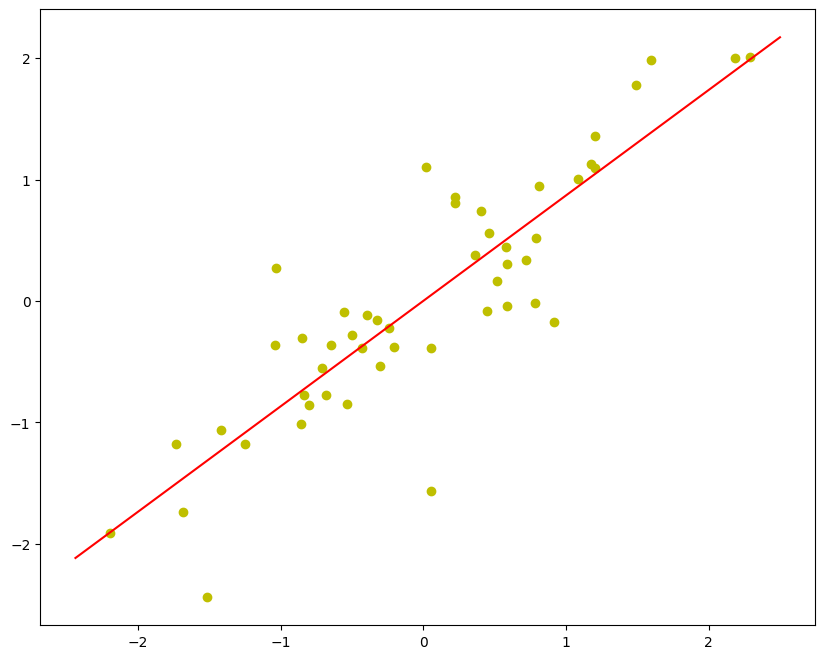

In [19]:
# Training loop
for e in range(100):
    for t, batch in enumerate(batches):
        y_hat = forward(gamma, X[batch])
        loss = loss_function(y_hat, y[batch]).mean()

        dw, db = gradients(gamma, X[batch], y[batch], y_hat)
        g = dw.mean(), db.mean()

        #adamax
        for i in range(len(g)):
            m[i] = (beta1 * m[i] + (1-beta1)) * g[i]
            u[i] = max(beta2 * u[i], abs(g[i]))
            gamma[i] -= (alpha / (1-beta1)) * m[i] / u[i]

    if((e+1) % 10 == 0):
        clear_output(wait=True)
        plt.figure(figsize=(10,8))
        plt.plot(X, y, 'yo')
        plt.plot(test, forward(gamma, test), 'r-')
        plt.show()

In [20]:
# Prediction function
def predict(gamma, X, scaler):
    """Predicts the profit for a given spending amount.

    Args:
        gamma: A list [w, b] where w is the weight and b is the bias.
        X: The spending amount.
        scaler: The scaler used to scale the data.

    Returns:
        The predicted profit.
    """
    X = scaler.transform([[X, 0.]])[0]
    z = forward(gamma, X)[0]
    z = scaler.inverse_transform([[0., z]])[0][0]
    return z

In [21]:
# Make a prediction
money_spent = data['Spent'].min()
money_spent = scaler.inverse_transform([[money_spent, 0.]])[0][0]

profit_made = predict(gamma, money_spent, scaler)
print("Money Spent:%6.2f$ - Profit:%6.2f$" % (money_spent, profit_made))

Money Spent:52285.20$ - Profit:406091.35$


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


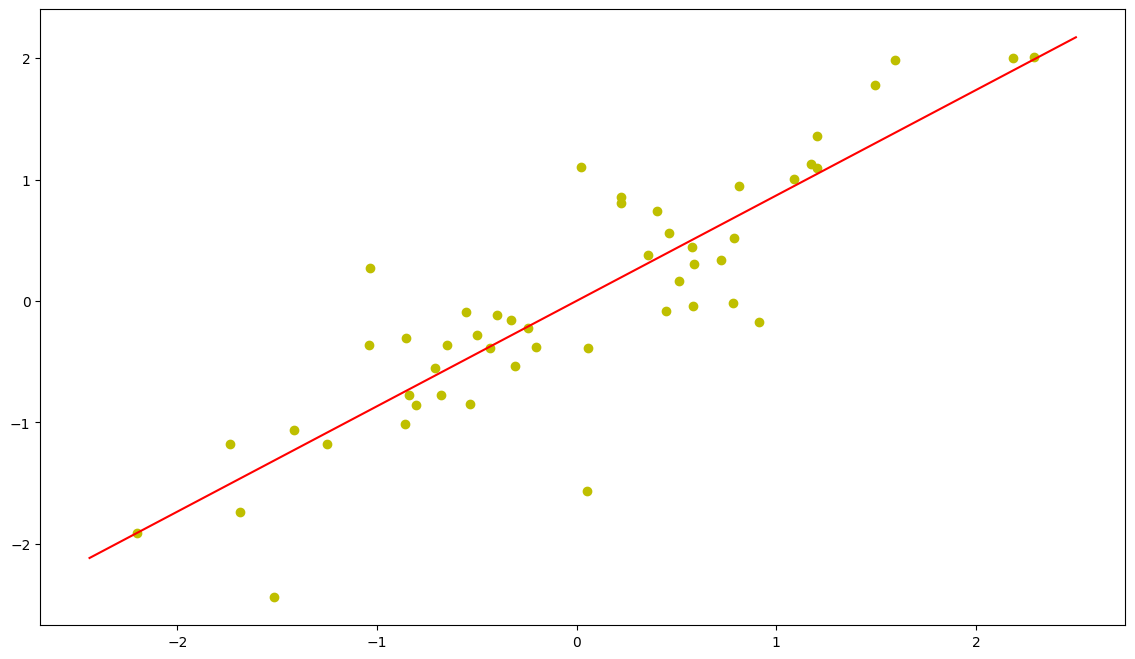

Mean Squared Error: 0.2386
R-squared: 0.7614


In [ ]:
# Training loop
for e in range(100):
    for t, batch in enumerate(batches):
        y_hat = forward(gamma, X[batch])  # Calculate y_hat for the batch
        loss = loss_function(y_hat, y[batch]).mean()

        dw, db = gradients(gamma, X[batch], y[batch], y_hat)
        g = dw.mean(), db.mean()

        #adamax
        for i in range(len(g)):
            m[i] = (beta1 * m[i] + (1-beta1)) * g[i]
            u[i] = max(beta2 * u[i], abs(g[i]))
            gamma[i] -= (alpha / (1-beta1)) * m[i] / u[i]

    # Moved the evaluation outside the batch loop
    if((e+1) % 10 == 0):
        clear_output(wait=True)
        plt.figure(figsize=(14,8))

        # Now we use the entire dataset X to get predictions for plotting
        y_hat = forward(gamma, X)
        plt.plot(X, y, 'yo')
        plt.plot(test, forward(gamma, test), 'r-')
        plt.show()

        # Calculate Mean Squared Error using the entire dataset
        mse = mean_squared_error(y, y_hat)
        # Calculate R-squared
        r2 = r2_score(y, y_hat)
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"R-squared: {r2:.4f}")